In [142]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold


In [143]:
X = pd.read_csv('Hotel Reservations.csv') # full model
y = X['booking_status']
X.drop(['booking_status', 'Booking_ID'], axis = 1, inplace = True)

In [138]:
X = pd.get_dummies(X)
y = pd.DataFrame(np.where(np.array(y=="Canceled"),1,0), columns=["cancelled"])
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=None, train_size=0.3)

## Kfold CV

In [114]:
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import KFold, RepeatedKFold
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
#
# # create K-fold object with 5 folds
# kf = RepeatedKFold(n_splits=5, random_state=8)
# models = {
#     "Logistic Regression": LogisticRegression(),
#     "Random Forest": RandomForestClassifier(),
#     "XGBoost": xgb.XGBClassifier(max_depth=10, learning_rate=0.1)
# }
# cv_scores = {}
# for name, model in models.items():
#     pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("clf", model)])
#     for train_index, test_index in kf.split(X_train):
#         pipeline.fit(X_train.iloc[train_index, :], y_train.iloc[train_index])
#         p_pred = pipeline.predict_proba(X_train.iloc[test_index, :])[:, 1]
#         cv_scores[name] = roc_auc_score(y_train.iloc[test_index], p_pred)
# print(cv_scores)

In [115]:
# Run CV for 5 folds
models = {
    # Baseline model
    "Naive Bayes" : GaussianNB(),
    # Linear model
    "Logistic Regression": LogisticRegression(),
    "RidgeClassifierCV": RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
    # Non-linear model
    "Neural_Network": MLPClassifier(hidden_layer_sizes = 100,learning_rate_init = 0.01),
    "svc": SVC(C = 1, gamma = 1, kernel = 'rbf'),
    # Tree based model
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(max_depth=10, learning_rate=0.1),
}

# Create folds
cv = RepeatedStratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Run for k folds to find best model.
cv_scores = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("clf", model)])
    cur_score = np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring = "roc_auc"))
    cv_scores[name] = cur_score
print(cv_scores)


{'Naive Bayes': 0.78482956703473, 'Logistic Regression': 0.8594775009597072, 'RidgeClassifierCV': 0.857547900758797, 'Neural_Network': 0.8992225158355438, 'svc': 0.8665645453708285, 'DecisionTreeClassifier': 0.8177323256539891, 'Random Forest': 0.9331536733303645, 'XGBoost': 0.942375625660642}


## Final model

In [118]:
final_model = RandomForestClassifier()
final_pip = Pipeline(steps=[("scaler", StandardScaler()), ("clf", final_model)])

final_pip.fit(X_train, y_train)
final_model = final_pip.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
classifier_score_xgb = roc_auc_score(y_test, y_pred)

print("The final roc auc score: ")
print(round(classifier_score_xgb,3))



The final roc auc score: 
0.863


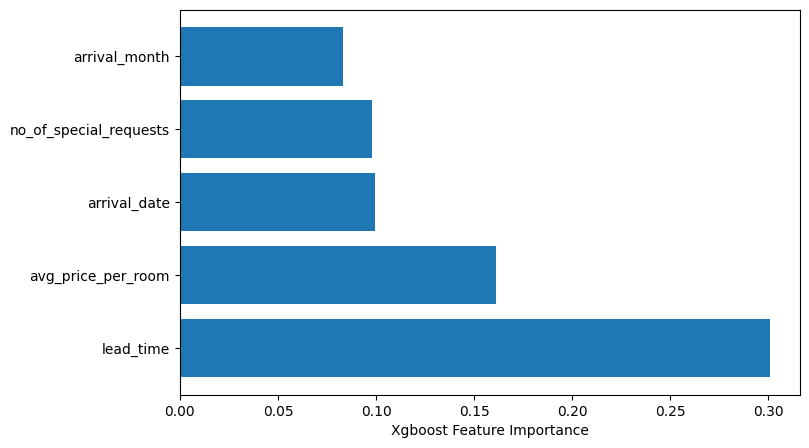

In [119]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
model = final_model["clf"]
sorted_idx = model.feature_importances_.argsort()[::-1]
top_n = 5  # Specify the number of top variables you want to display

plt.figure(figsize=(8, 5))  # Set the figure size
plt.barh(range(top_n), model.feature_importances_[sorted_idx][:top_n], align='center')
plt.yticks(range(top_n), X_test.columns[sorted_idx][:top_n])
plt.xlabel("Xgboost Feature Importance")

plt.show()
